In [ ]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
random.seed(42)

brands = ['Toyota', 'Honda', 'Ford', 'BMW', 'Hyundai', 'Nissan', 'Kia', 'Chevrolet', 'Volkswagen', 'Mercedes']
fuel_types = ['Petrol', 'Diesel', 'Electric', 'Hybrid']
transmissions = ['Manual', 'Automatic']

data = {
    'brand': [random.choice(brands) for _ in range(1000)],
    'model_year': [random.randint(2005, 2022) for _ in range(1000)],
    'mileage': [random.randint(5000, 200000) for _ in range(1000)],
    'engine_size': [round(random.uniform(1.0, 4.5), 1) for _ in range(1000)],
    'fuel_type': [random.choice(fuel_types) for _ in range(1000)],
    'transmission': [random.choice(transmissions) for _ in range(1000)],
}

df = pd.DataFrame(data)

def base_price(row):
    base = 5000
    brand_factor = {
        'BMW': 10000, 'Mercedes': 11000, 'Toyota': 4000, 'Honda': 4500,
        'Ford': 3000, 'Hyundai': 3500, 'Nissan': 3600, 'Kia': 3300,
        'Chevrolet': 3100, 'Volkswagen': 5000
    }
    price = base + brand_factor[row['brand']]
    price += (row['engine_size'] - 1.0) * 2000
    price -= (2025 - row['model_year']) * 500
    price -= (row['mileage'] / 1000) * 100
    if row['fuel_type'] == 'Electric':
        price += 5000
    if row['fuel_type'] == 'Hybrid':
        price += 3000
    if row['transmission'] == 'Automatic':
        price += 1000
    return max(1000, int(price + np.random.normal(0, 2000)))

df['price'] = df.apply(base_price, axis=1)
df.to_csv('car_data.csv', index=False)
print("Large car_data.csv with 1000 entries created")


Large car_data.csv with 1000 entries created


In [ ]:
!pip install xgboost
!pip install tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Linear Regression
R2 Score: 0.3019437167401188
MSE: 7317072.377946346

XGBoost
R2 Score: 0.6839478611946106
MSE: 3312879.25

Neural Network
R2 Score: 0.3565564751625061
MSE: 6744617.5



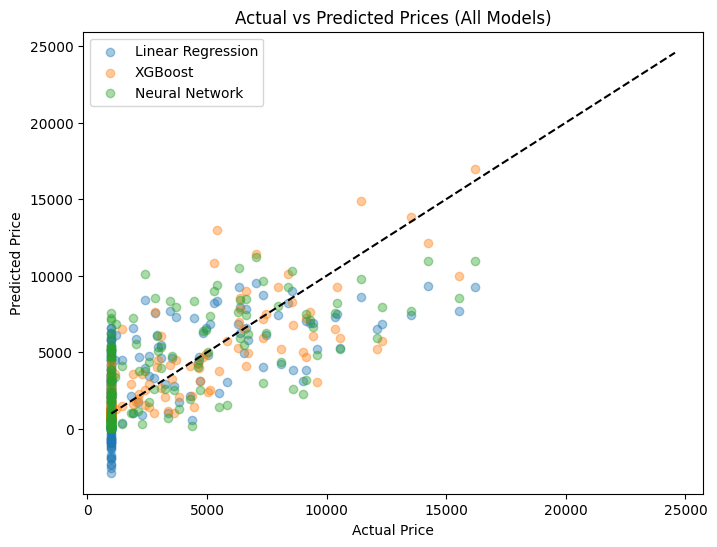

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('car_data.csv')

for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

nn = Sequential()
nn.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(1))
nn.compile(optimizer='adam', loss='mse')
nn.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
nn_pred = nn.predict(X_test_scaled).flatten()

def evaluate(y_true, y_pred, model_name):
    print(model_name)
    print('R2 Score:', r2_score(y_true, y_pred))
    print('MSE:', mean_squared_error(y_true, y_pred))
    print()

evaluate(y_test, lr_pred, 'Linear Regression')
evaluate(y_test, xgb_pred, 'XGBoost')
evaluate(y_test, nn_pred, 'Neural Network')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, lr_pred, alpha=0.4, label='Linear Regression')
plt.scatter(y_test, xgb_pred, alpha=0.4, label='XGBoost')
plt.scatter(y_test, nn_pred, alpha=0.4, label='Neural Network')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (All Models)')
plt.legend()
plt.show()
